<a href="https://colab.research.google.com/github/kairamilanifitria/DeepLearning/blob/main/Film_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
import json
import pandas as pd
#___________________________
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________________
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']
#____________________________________
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}
#_____________________________________________________
IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}
#_____________________________________________________
def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
#_____________________________________________________
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
#_____________________________________________________
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])
#_____________________________________________________
def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [148]:
from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/research/movies/TMDB 5000 Movie Dataset/"]).decode("utf8"))

tmdb_5000_credits.csv
tmdb_5000_movies.csv



In [149]:
def safe_access(container, index_values):
    try:
        result = container
        for idx in index_values:
            if isinstance(result, list) or isinstance(result, pd.Series):
                if len(result) > idx:
                    result = result[idx]
                else:
                    return np.nan
            elif isinstance(result, dict):
                result = result.get(idx)
                if result is None:
                    return np.nan
            else:
                return np.nan
        return result
    except (IndexError, KeyError):
        return np.nan


In [150]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()


In [151]:
# load the necessary libraries
import pandas as pd

# load the dataset
credits = load_tmdb_credits("/content/drive/MyDrive/research/movies/TMDB 5000 Movie Dataset/tmdb_5000_credits.csv")
movies = load_tmdb_movies("/content/drive/MyDrive/research/movies/TMDB 5000 Movie Dataset/tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:', df_initial.shape)

#__________________________________________
# info on variable types and filling factor
tab_info = pd.concat([pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'}),
                      pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values'}),
                      pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.rename(index={0: 'null values (%)'})])

print(tab_info.to_string())


Shape: (4803, 26)
                budget  genres   homepage     id plot_keywords  language original_title  overview popularity production_companies production_countries release_date  gross  duration spoken_languages  status    tagline movie_title vote_average num_voted_users title_year   country director_name actor_1_name actor_2_name actor_3_name
column type      int64  object     object  int64        object    object         object    object    float64               object               object       object  int64   float64           object  object     object      object      float64           int64    float64    object        object       object       object       object
null values          0       0       3091      0             0        86              0         3          0                    0                    0            1      0         2                0       0        844           0            0               0          1       174            30           53           63

In [152]:
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)
#_________________________
# remove null chain entry
set_keywords.remove('')

In [153]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in [s for s in liste_keywords if s in liste]:
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [154]:
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

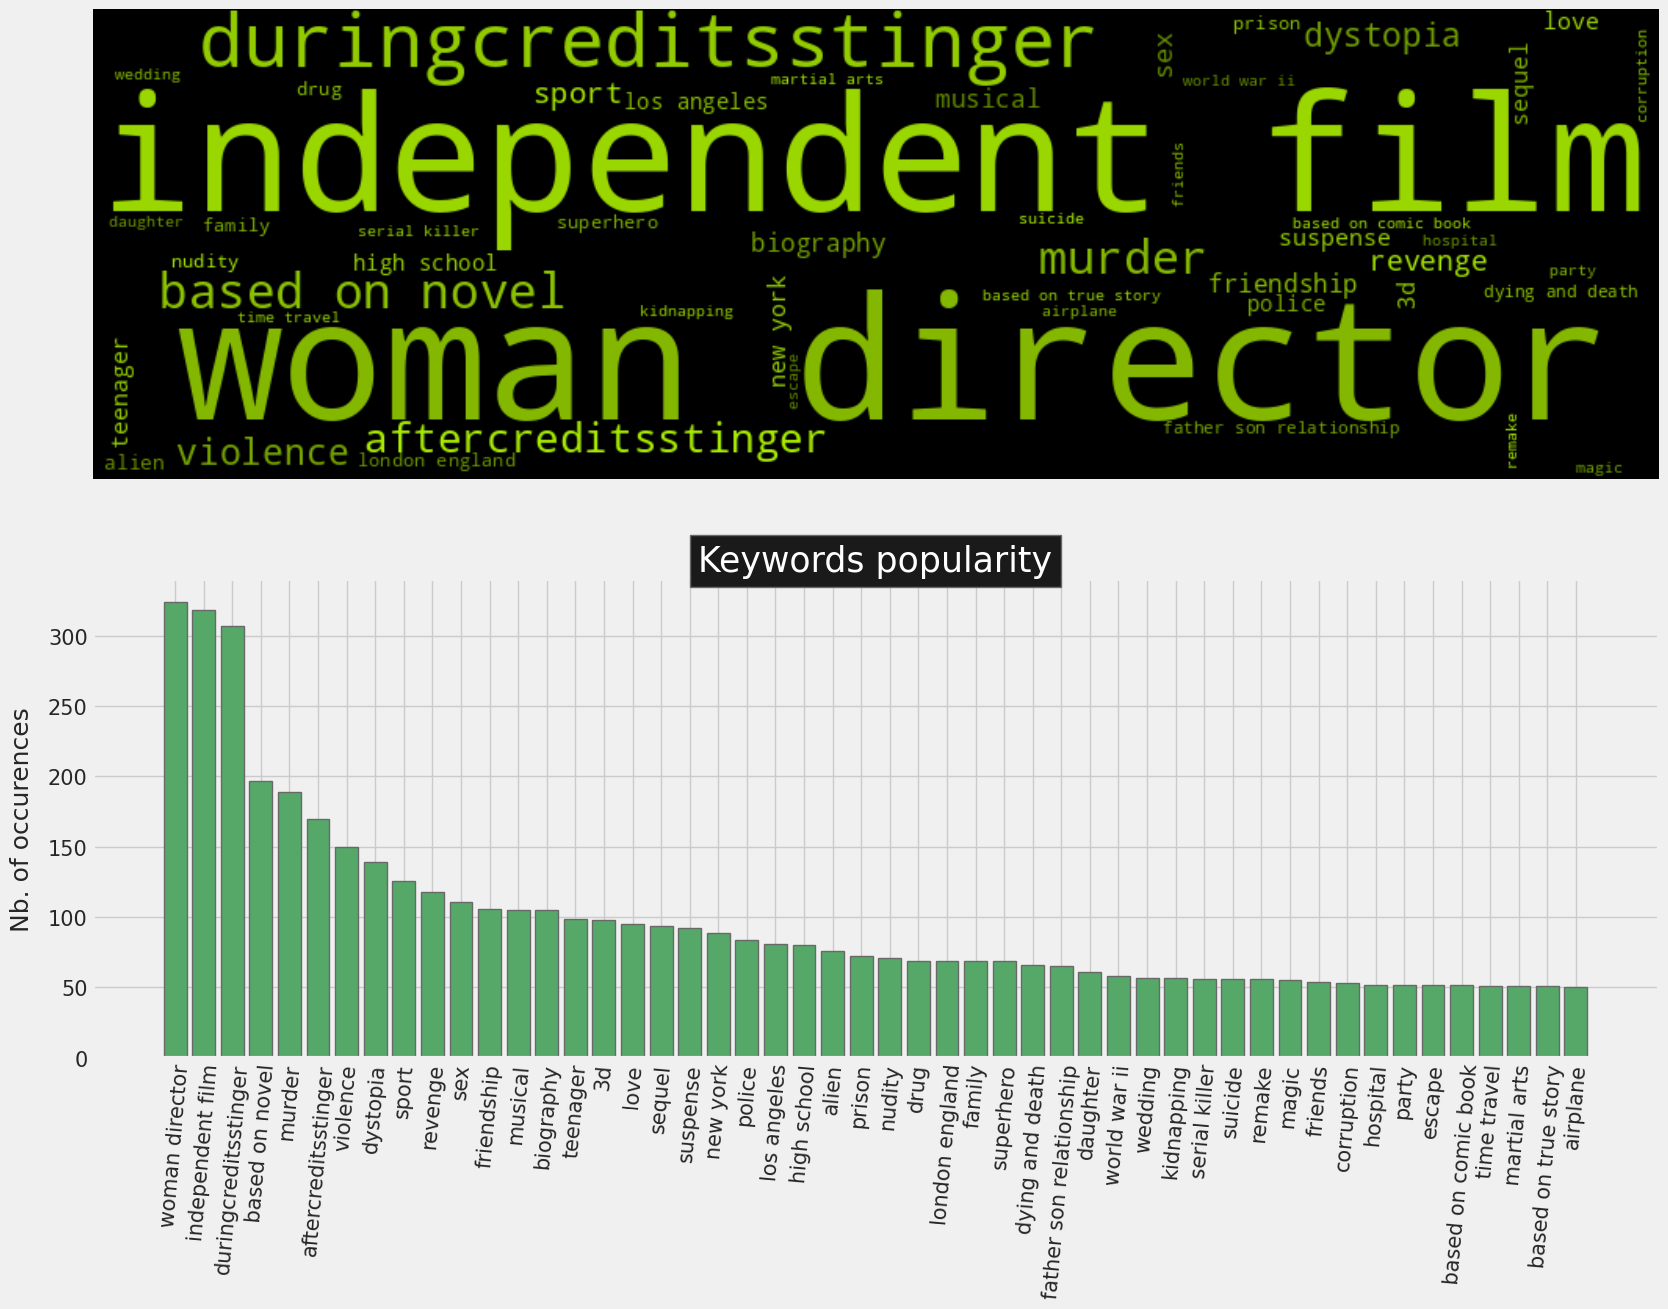

In [155]:
#_____________________________________________
# Function that control the color of the words
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# WARNING: the scope of variables is used to get the value of the "tone" variable
# I could not find the way to pass it as a parameter of "random_color_func()"
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=1000,height=300, background_color='black',
                      max_words=1628,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
#_____________________________________________
# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

In [156]:
# load the necessary libraries
import pandas as pd

# Assuming df_initial and missing_df are already defined

missing_df = df_initial.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_initial.shape[0]
                                - missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop=True)

# Convert DataFrame to string format and print
print(missing_df.to_string(index=False))


         column_name  missing_count  filling_factor
            homepage           3091       35.644389
             tagline            844       82.427649
             country            174       96.377264
        actor_3_name             93       98.063710
            language             86       98.209452
        actor_2_name             63       98.688320
        actor_1_name             53       98.896523
       director_name             30       99.375390
            overview              3       99.937539
            duration              2       99.958359
          title_year              1       99.979180
        release_date              1       99.979180
     num_voted_users              0      100.000000
        vote_average              0      100.000000
         movie_title              0      100.000000
              budget              0      100.000000
    spoken_languages              0      100.000000
production_countries              0      100.000000
production_c

In [157]:
# number of film per year
df_initial['decade'] = df_initial['title_year'].apply(lambda x:((x-1900)//10)*10)
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
#______________________________________________________________
# Creation of a dataframe with statitical infos on each decade:
test = df_initial['title_year'].groupby(df_initial['decade']).apply(get_stats).unstack()

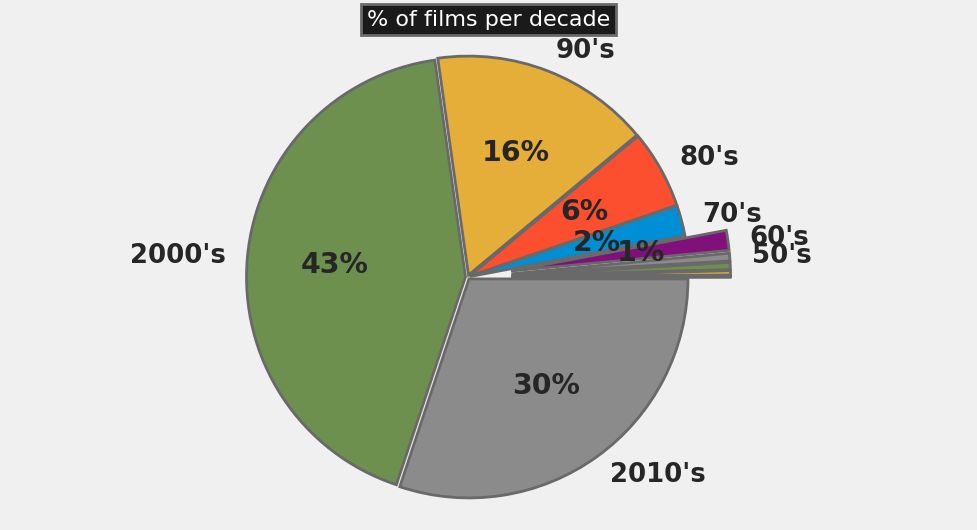

In [158]:
sns.set_context("poster", font_scale=0.85)
#_______________________________
# funtion used to set the labels
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
#____________________________________
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)

In [159]:
# genre

genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [160]:
keyword_occurences, dum = count_word(df_initial, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

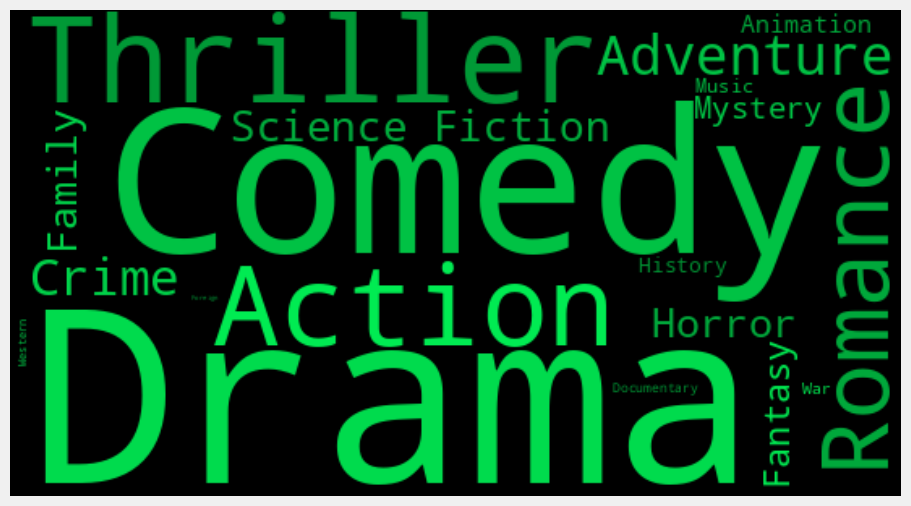

In [161]:
# wordcloud
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black',
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


cleaning

In [162]:
df_duplicate_cleaned = df_initial

In [163]:
# Collect the keywords
#----------------------
def keywords_inventory(dataframe, colonne = 'plot_keywords'):
    PS = nltk.stem.PorterStemmer()
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower() ; racine = PS.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
            else:
                keywords_roots[racine] = {t}

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

In [164]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_duplicate_cleaned, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 9474


In [165]:
# Plot of a sample of keywords that appear in close varieties
#------------------------------------------------------------
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1:
        icount += 1
        if icount < 15: print(icount, keywords_roots[s], len(keywords_roots[s]))

1 {'alienation', 'alien'} 2
2 {'spy', 'spying'} 2
3 {'vigilantism', 'vigilante'} 2
4 {'terror', 'terrorism'} 2
5 {'flooding', 'flood'} 2
6 {'spider', 'spiders'} 2
7 {'horse', 'horses'} 2
8 {'musical', 'music'} 2
9 {'animal', 'animation', 'anime'} 3
10 {'compass', 'compassion'} 2
11 {'training', 'train'} 2
12 {'sail', 'sailing'} 2
13 {'time traveler', 'time travel'} 2
14 {'orc', 'orcs'} 2


In [166]:
# Replacement of the keywords by the main form
#----------------------------------------------
def remplacement_df_keywords(df, dico_remplacement, roots=False):
    df_new = df.copy(deep=True)
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine):
            continue
        nouvelle_liste = []
        for s in chaine.split('|'):
            clef = PS.stem(s) if roots else s
            if clef in dico_remplacement.keys():
                nouvelle_liste.append(dico_remplacement[clef])
            else:
                nouvelle_liste.append(s)
        df_new.at[index, 'plot_keywords'] = '|'.join(nouvelle_liste)
    return df_new

In [167]:
# Replacement of the keywords by the main keyword
#-------------------------------------------------
df_keywords_cleaned = remplacement_df_keywords(df_duplicate_cleaned, keywords_select, roots=True)

In [168]:
# Count of the keywords occurences
#----------------------------------
keywords.remove('')
keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'plot_keywords',keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [169]:
# get the synomyms of the word 'mot_cle'
#--------------------------------------------------------------
def get_synonymes(mot_cle):
    lemma = set()
    for ss in wordnet.synsets(mot_cle):
        for w in ss.lemma_names():
            #_______________________________
            # We just get the 'nouns':
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma

In [170]:
# Exemple of a list of synonyms given by NLTK
#---------------------------------------------------
mot_cle = 'alien'
lemma = get_synonymes(mot_cle)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords, keywords_count[s] if s in keywords else 0 ))

 "unknown                       " in keywords list -> False 0
 "foreigner                     " in keywords list -> False 0
 "extraterrestrial              " in keywords list -> True 4
 "alien                         " in keywords list -> True 80
 "noncitizen                    " in keywords list -> False 0
 "outlander                     " in keywords list -> False 0
 "extraterrestrial being        " in keywords list -> False 0
 "stranger                      " in keywords list -> True 7


In [171]:
# check if 'mot' is a key of 'key_count' with a test on the number of occurences
#----------------------------------------------------------------------------------
def test_keyword(mot, key_count, threshold):
    return (False , True)[key_count.get(mot, 0) >= threshold]

In [172]:
keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
#__________________________________________________________________________
# Creation of a dictionary to replace keywords by higher frequency keywords
remplacement_mot = dict()
icount = 0
for index, [mot, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue  # only the keywords that appear less than 5 times
    lemma = get_synonymes(mot)
    if len(lemma) == 0: continue     # case of the plurals
    #_________________________________________________________________
    liste_mots = [(s, key_count[s]) for s in lemma
                  if test_keyword(s, key_count, key_count[mot])]
    liste_mots.sort(key = lambda x:(x[1],x[0]), reverse = True)
    if len(liste_mots) <= 1: continue       # no replacement
    if mot == liste_mots[0][0]: continue    # replacement by himself
    icount += 1
    if  icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(mot, liste_mots[0][0], liste_mots))
    remplacement_mot[mot] = liste_mots[0][0]

print(90*'_'+'\n'+'The replacement concerns {}% of the keywords.'
      .format(round(len(remplacement_mot)/len(keywords)*100,2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
The replacement concerns 5.99% of the keywords.


In [173]:
# 2 successive replacements
#---------------------------
print('Keywords that appear both in keys and values:'.upper()+'\n'+45*'-')
icount = 0
for s in remplacement_mot.values():
    if s in remplacement_mot.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, remplacement_mot[s]))

for key, value in remplacement_mot.items():
    if value in remplacement_mot.keys():
        remplacement_mot[key] = remplacement_mot[value]

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


In [174]:
# replacement of keyword varieties by the main keyword
#----------------------------------------------------------
df_keywords_synonyms = \
            remplacement_df_keywords(df_keywords_cleaned, remplacement_mot, roots = False)
keywords, keywords_roots, keywords_select = \
            keywords_inventory(df_keywords_synonyms, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 8908


In [175]:
# New count of keyword occurences
#-------------------------------------
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms, 'plot_keywords',keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [176]:
# deletion of keywords with low frequencies
def remplacement_df_low_frequency_keywords(df, keyword_occurences):
    df_new = df.copy(deep=True)
    key_count = {s[0]: s[1] for s in keyword_occurences}
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine):
            continue
        nouvelle_liste = []
        for s in chaine.split('|'):
            if key_count.get(s, 4) > 3:
                nouvelle_liste.append(s)
        df_new.at[index, 'plot_keywords'] = '|'.join(nouvelle_liste)
    return df_new


In [177]:
# Creation of a dataframe where keywords of low frequencies are suppressed
#-------------------------------------------------------------------------

df_keywords_occurence = remplacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, keywords_select = keywords_inventory(df_keywords_occurence, colonne='plot_keywords')

Nb of keywords in variable 'plot_keywords': 2120


In [178]:
# New keywords count
#-------------------
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence, 'plot_keywords',keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

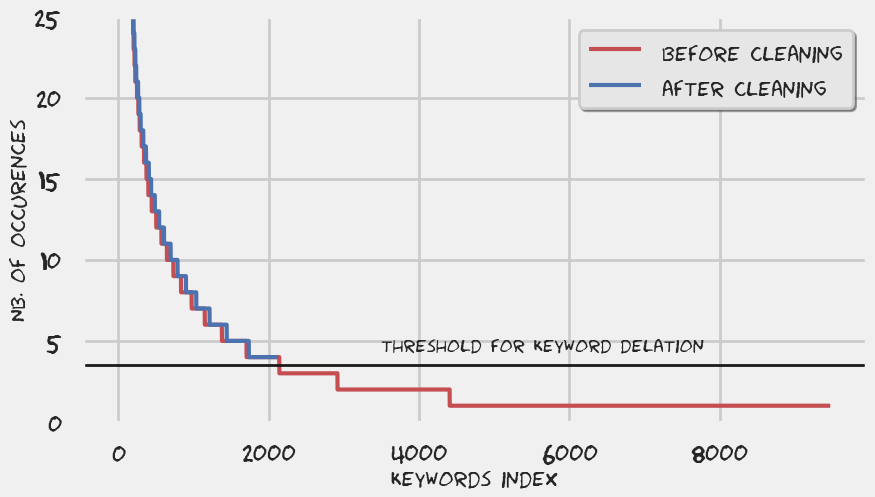

In [179]:
# Graph of keyword occurences
#----------------------------
font = {'family' : 'fantasy', 'weight' : 'normal', 'size'   : 15}
mpl.rc('font', **font)

keyword_occurences.sort(key = lambda x:x[1], reverse = True)

y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]

new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k,i in enumerate(new_keyword_occurences)]

f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, y_axis, 'r-', label='before cleaning')
ax.plot(new_x_axis, new_y_axis, 'b-', label='after cleaning')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')

plt.ylim((0,25))
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("keywords index", family='fantasy', fontsize = 15)
plt.ylabel("Nb. of occurences", family='fantasy', fontsize = 15)
#plt.suptitle("Nombre d'occurences des mots clés", fontsize = 18, family='fantasy')
plt.text(3500, 4.5, 'threshold for keyword delation', fontsize = 13)
plt.show()

In [180]:
# Drop non-numeric columns
df_numeric = df_keywords_occurence.select_dtypes(include=[np.number])

# Calculations of correlations
corrmat = df_numeric.dropna(how='any').corr()

# Rest of your code for plotting the heatmap...

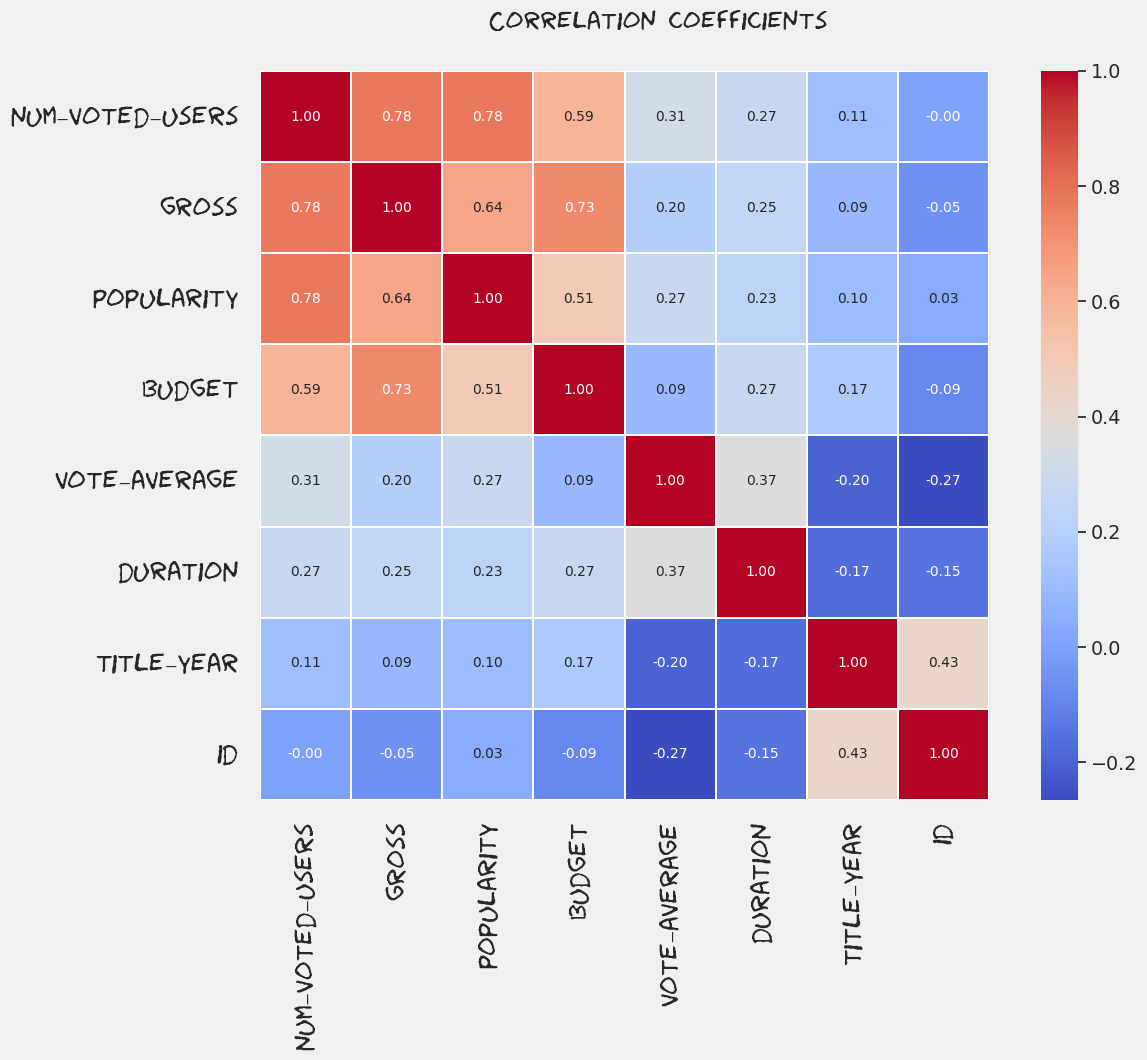

In [181]:
# correlations
f, ax = plt.subplots(figsize=(12, 9))
#_____________________________

#________________________________________
k = 17 # number of variables for heatmap
cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation coefficients", ha='center', fontsize = 18, family='fantasy')
plt.show()




In [182]:
df_var_cleaned = df_keywords_occurence.copy(deep = True)

In [183]:
# missing value

missing_df = df_var_cleaned.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_var_cleaned.shape[0] - missing_df['missing_count']) / df_var_cleaned.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop=True)

# Convert DataFrame to string format and print
print(missing_df.to_string(index=False))


         column_name  missing_count  filling_factor
            homepage           3091       35.644389
             tagline            844       82.427649
             country            174       96.377264
        actor_3_name             93       98.063710
            language             86       98.209452
        actor_2_name             63       98.688320
        actor_1_name             53       98.896523
       director_name             30       99.375390
            overview              3       99.937539
            duration              2       99.958359
          title_year              1       99.979180
        release_date              1       99.979180
     num_voted_users              0      100.000000
        vote_average              0      100.000000
         movie_title              0      100.000000
              budget              0      100.000000
    spoken_languages              0      100.000000
production_countries              0      100.000000
production_c

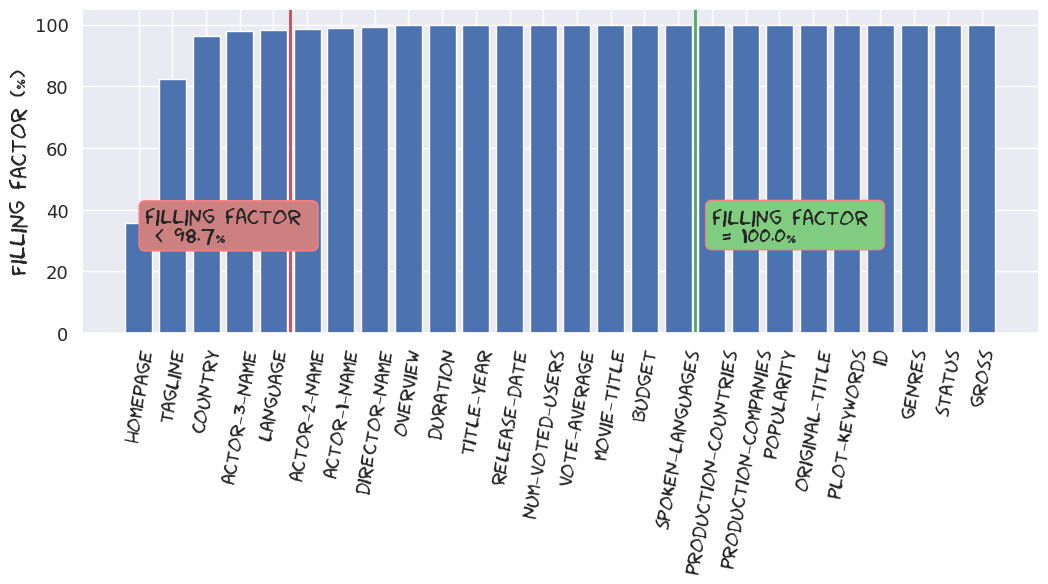

In [184]:
y_axis = missing_df['filling_factor']
x_label = missing_df['column_name']
x_axis = missing_df.index

fig = plt.figure(figsize=(11, 4))
plt.xticks(rotation=80, fontsize = 14)
plt.yticks(fontsize = 13)

N_thresh = 5
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'r')
plt.text(N_thresh-4.8, 30, 'filling factor \n < {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1.0, 0.5, 0.5),
                   fc=(0.8, 0.5, 0.5)))
N_thresh = 17
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'g')
plt.text(N_thresh, 30, 'filling factor \n = {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(0.5, 0.8, 0.5)))

plt.xticks(x_axis, x_label,family='fantasy', fontsize = 14 )
plt.ylabel('Filling factor (%)', family='fantasy', fontsize = 16)
plt.bar(x_axis, y_axis);

In [185]:
# Setting missing title years
df_filling = df_var_cleaned.copy(deep=True)
missing_year_info = df_filling[df_filling['title_year'].isnull()][['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']]
# Convert DataFrame to string format and print
print(missing_year_info[:10].to_string(index=False))


director_name actor_1_name actor_2_name actor_3_name
          NaN          NaN          NaN          NaN


In [186]:
df_filling.iloc[4553]

budget                                                                  0
genres                                                                   
homepage                                                              NaN
id                                                                 380097
plot_keywords                                                            
language                                                              NaN
original_title                                 America Is Still the Place
overview                1971 post civil rights San Francisco seemed li...
popularity                                                            0.0
production_companies                                                   []
production_countries                                                   []
release_date                                                          NaT
gross                                                                   0
duration                              

In [187]:
def fill_year(df):
    col = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']
    usual_year = [0 for _ in range(4)]
    var        = [0 for _ in range(4)]
    #_____________________________________________________________
    # I get the mean years of activity for the actors and director
    for i in range(4):
        usual_year[i] = df.groupby(col[i])['title_year'].mean()
    #_____________________________________________
    # I create a dictionnary collectinf this info
    actor_year = dict()
    for i in range(4):
        for s in usual_year[i].index:
            if s in actor_year.keys():
                if pd.notnull(usual_year[i][s]) and pd.notnull(actor_year[s]):
                    actor_year[s] = (actor_year[s] + usual_year[i][s])/2
                elif pd.isnull(actor_year[s]):
                    actor_year[s] = usual_year[i][s]
            else:
                actor_year[s] = usual_year[i][s]

    #______________________________________
    # identification of missing title years
    missing_year_info = df[df['title_year'].isnull()]
    #___________________________
    # filling of missing values
    icount_replaced = 0
    for index, row in missing_year_info.iterrows():
        value = [ np.NaN for _ in range(4)]
        icount = 0 ; sum_year = 0
        for i in range(4):
            var[i] = df.loc[index][col[i]]
            if pd.notnull(var[i]): value[i] = actor_year[var[i]]
            if pd.notnull(value[i]): icount += 1 ; sum_year += actor_year[var[i]]
        if icount != 0: sum_year = sum_year / icount

        if int(sum_year) > 0:
            icount_replaced += 1
            df.at[index, 'title_year'] = int(sum_year)
            if icount_replaced < 10:
                print("{:<45} -> {:<20}".format(df.loc[index]['movie_title'],int(sum_year)))
    return

In [188]:
fill_year(df_filling)

In [189]:
# Extracting keywords from the title

icount = 0
for index, row in df_filling[df_filling['plot_keywords'].isnull()].iterrows():
    icount += 1
    liste_mot = row['movie_title'].strip().split()
    new_keyword = []
    for s in liste_mot:
        lemma = get_synonymes(s)
        for t in list(lemma):
            if t in keywords:
                new_keyword.append(t)
    if new_keyword and icount < 15:
        print('{:<50} -> {:<30}'.format(row['movie_title'], str(new_keyword)))
    if new_keyword:
        df_filling.at[index, 'plot_keywords'] = '|'.join(new_keyword)

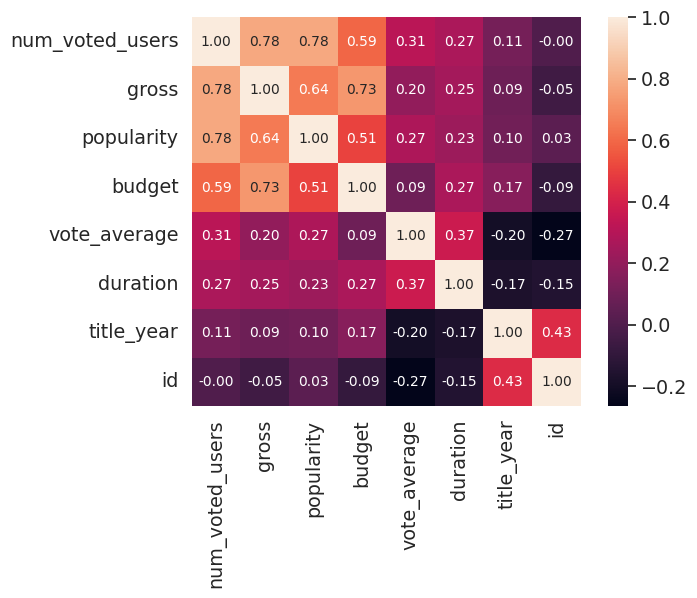

In [190]:
cols = corrmat.nlargest(9, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

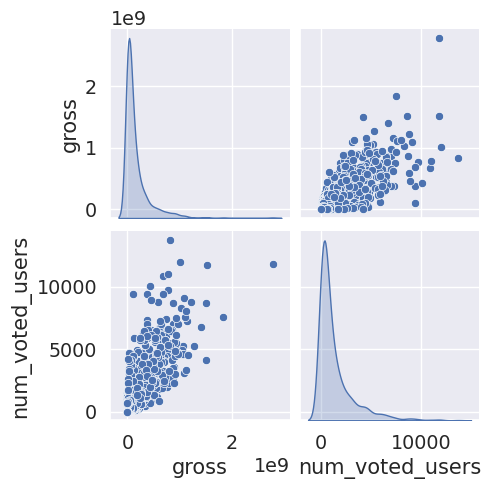

In [191]:
sns.set(font_scale=1.25)
cols = ['gross', 'num_voted_users']
sns.pairplot(df_filling.dropna(how='any')[cols],diag_kind='kde', size = 2.5)
plt.show();

In [192]:
def variable_linreg_imputation(df, col_to_predict, ref_col):
    regr = linear_model.LinearRegression()
    test = df[[col_to_predict,ref_col]].dropna(how='any', axis = 0)
    X = np.array(test[ref_col])
    Y = np.array(test[col_to_predict])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr.fit(X, Y)

    test = df[df[col_to_predict].isnull() & df[ref_col].notnull()]
    for index, row in test.iterrows():
        value = float(regr.predict(row[ref_col]))
        df.at[index, col_to_predict] = value

In [193]:
variable_linreg_imputation(df_filling, 'gross', 'num_voted_users')

In [194]:
# examine which amount of data is still missing in the dataframe
df = df_filling.copy(deep = True)
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df.shape[0]
                                - missing_df['missing_count']) / df.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

print(missing_df.to_string(index=False))

         column_name  missing_count  filling_factor
            homepage           3091       35.644389
             tagline            844       82.427649
             country            174       96.377264
        actor_3_name             93       98.063710
            language             86       98.209452
        actor_2_name             63       98.688320
        actor_1_name             53       98.896523
       director_name             30       99.375390
            overview              3       99.937539
            duration              2       99.958359
          title_year              1       99.979180
        release_date              1       99.979180
     num_voted_users              0      100.000000
        vote_average              0      100.000000
         movie_title              0      100.000000
              budget              0      100.000000
    spoken_languages              0      100.000000
production_countries              0      100.000000
production_c

In [195]:
df = df_filling.copy(deep=True)
df.reset_index(inplace = True, drop = True)

# recommendation model

In [208]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))

In [209]:
def entry_variables(df, id_entry):
    col_labels = []
    if pd.notnull(df['director_name'].iloc[id_entry]):
        for s in df['director_name'].iloc[id_entry].split('|'):
            col_labels.append(s)

    for i in range(3):
        column = 'actor_NUM_name'.replace('NUM', str(i+1))
        if pd.notnull(df[column].iloc[id_entry]):
            for s in df[column].iloc[id_entry].split('|'):
                col_labels.append(s)

    if pd.notnull(df['plot_keywords'].iloc[id_entry]):
        for s in df['plot_keywords'].iloc[id_entry].split('|'):
            col_labels.append(s)
    return col_labels

In [210]:
def add_variables(df, REF_VAR):
    for s in REF_VAR:
        df[s] = pd.Series([0 for _ in range(len(df))])
    colonnes = ['genres', 'actor_1_name', 'actor_2_name',
                'actor_3_name', 'director_name', 'plot_keywords']
    for categorie in colonnes:
        for index, row in df.iterrows():
            if pd.isnull(row[categorie]):
                continue
            for s in row[categorie].split('|'):
                if s in REF_VAR:
                    df.at[index, s] = 1
    return df

In [211]:
def recommand(df, id_entry):
    df_copy = df.copy(deep=True)
    liste_genres = set()
    for s in df['genres'].str.split('|').values:
        liste_genres = liste_genres.union(set(s))

    # Create additional variables to check the similarity
    variables = entry_variables(df_copy, id_entry)
    variables += list(liste_genres)
    df_new = add_variables(df_copy, variables)

    print("df_new:", df_new)
    print("variables:", variables)

    # Determination of the closest neighbors: the distance is calculated using new variables
    X = df_new.values[:, variables]
    nbrs = NearestNeighbors(n_neighbors=31, algorithm='auto', metric='euclidean').fit(X)
    xtest = df_new.iloc[id_entry].values[variables].reshape(1, -1)
    distances, indices = nbrs.kneighbors(xtest)
    return indices[0][:]


In [212]:
def extract_parameters(df, liste_films):
    parametres_films = ['_' for _ in range(31)]
    i = 0
    max_users = -1
    for index in liste_films:
        parametres_films[i] = list(df.iloc[index][['movie_title', 'title_year',
                                        'imdb_score', 'num_user_for_reviews',
                                        'num_voted_users']])
        parametres_films[i].append(index)
        max_users = max(max_users, parametres_films[i][4] )
        i += 1

    title_main = parametres_films[0][0]
    annee_ref  = parametres_films[0][1]
    parametres_films.sort(key = lambda x:critere_selection(title_main, max_users,
                                    annee_ref, x[0], x[1], x[2], x[4]), reverse = True)

    return parametres_films

In [213]:
def sequel(titre_1, titre_2):
    if fuzz.ratio(titre_1, titre_2) > 50 or fuzz.token_set_ratio(titre_1, titre_2) > 50:
        return True
    else:
        return False

In [214]:
def critere_selection(title_main, max_users, annee_ref, titre, annee, imdb_score, votes):
    if pd.notnull(annee_ref):
        facteur_1 = gaussian_filter(annee_ref, annee, 20)
    else:
        facteur_1 = 1

    sigma = max_users * 1.0

    if pd.notnull(votes):
        facteur_2 = gaussian_filter(votes, max_users, sigma)
    else:
        facteur_2 = 0

    if sequel(title_main, titre):
        note = 0
    else:
        note = imdb_score**2 * facteur_1 * facteur_2

    return note

In [215]:
def add_to_selection(film_selection, parametres_films):
    film_list = film_selection[:]
    icount = len(film_list)
    for i in range(31):
        already_in_list = False
        for s in film_selection:
            if s[0] == parametres_films[i][0]: already_in_list = True
            if sequel(parametres_films[i][0], s[0]): already_in_list = True
        if already_in_list: continue
        icount += 1
        if icount <= 5:
            film_list.append(parametres_films[i])
    return film_list

In [216]:
def remove_sequels(film_selection):
    removed_from_selection = []
    for i, film_1 in enumerate(film_selection):
        for j, film_2 in enumerate(film_selection):
            if j <= i: continue
            if sequel(film_1[0], film_2[0]):
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)

    film_list = [film for film in film_selection if film[0] not in removed_from_selection]

    return film_list

In [217]:
def find_similarities(df, id_entry, del_sequels = True, verbose = False):
    if verbose:
        print(90*'_' + '\n' + "QUERY: films similar to id={} -> '{}'".format(id_entry,
                                df.iloc[id_entry]['movie_title']))
    #____________________________________
    liste_films = recommand(df, id_entry)
    #__________________________________
    # Create a list of 31 films
    parametres_films = extract_parameters(df, liste_films)
    #_______________________________________
    # Select 5 films from this list
    film_selection = []
    film_selection = add_to_selection(film_selection, parametres_films)
    #__________________________________
    # delation of the sequels
    if del_sequels: film_selection = remove_sequels(film_selection)
    #______________________________________________
    # add new films to complete the list
    film_selection = add_to_selection(film_selection, parametres_films)
    #_____________________________________________
    selection_titres = []
    for i,s in enumerate(film_selection):
        selection_titres.append([s[0].replace(u'\xa0', u''), s[5]])
        if verbose: print("nº{:<2}     -> {:<30}".format(i+1, s[0]))

    return selection_titres

make a recommendation

In [219]:
dum = find_similarities(df, 12, del_sequels = False, verbose = True)
print("Variables:", variables)
X = df_new.values[:, variables]

__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
df_new:          budget                                    genres  \
0     237000000  Action|Adventure|Fantasy|Science Fiction   
1     300000000                  Adventure|Fantasy|Action   
2     245000000                    Action|Adventure|Crime   
3     250000000               Action|Crime|Drama|Thriller   
4     260000000          Action|Adventure|Science Fiction   
...         ...                                       ...   
4798     220000                     Action|Crime|Thriller   
4799       9000                            Comedy|Romance   
4800          0             Comedy|Drama|Romance|TV Movie   
4801          0                                             
4802          0                               Documentary   

                                               homepage      id  \
0                      

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
dum = find_similarities(df, 12, del_sequels = True, verbose = True)

In [ ]:
dum = find_similarities(df, 2, del_sequels = True, verbose = True)

In [ ]:
selection = dict()
for i in range(0, 20, 3):
    selection[i] = find_similarities(df, i, del_sequels = True, verbose = True)